In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
        
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import pandas as pd
import shutil
import random
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

# Any results you write to the current directory are saved as output.

In [22]:
INPUT_DIR = 'input/covid-chest-xray'

In [38]:
SAMPLES = 25

In [23]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([INPUT_DIR, "metadata.csv"])
df = pd.read_csv(csvPath)

In [24]:
df.head(2)

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,needed_supplemental_O2,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 27
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,infiltrate in the upper lobe of the left lung,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN


In [25]:
DATA_SET_DIR = 'dataset'

In [26]:
df['finding'].value_counts()

COVID-19          253
Streptococcus      17
SARS               16
Pneumocystis       15
COVID-19, ARDS     12
ARDS                4
E.Coli              4
No Finding          3
Chlamydophila       2
Legionella          2
Klebsiella          1
Name: finding, dtype: int64

In [27]:
df['view'].value_counts()

PA               190
Axial             41
AP                38
AP Supine         29
L                 27
Coronal            3
AP semi erect      1
Name: view, dtype: int64

In [28]:
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([INPUT_DIR, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{DATA_SET_DIR}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [34]:
pneumonia_dataset_path ='input/chest-xray-pneumonia/chest_xray'

In [35]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))


In [36]:
imagePaths

['input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0427-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0561-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1110-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0757-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1326-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0736-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0500-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0393-0001.jpeg',
 'input/chest-xray-pneumonia/chest_xray/train/NORMAL/NO

In [40]:
# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:SAMPLES]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{DATA_SET_DIR}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [41]:
#helper functions to plot them in a grid
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [42]:
normal_images = list(paths.list_images(f"{DATA_SET_DIR}/normal"))
covid_images = list(paths.list_images(f"{DATA_SET_DIR}/covid"))

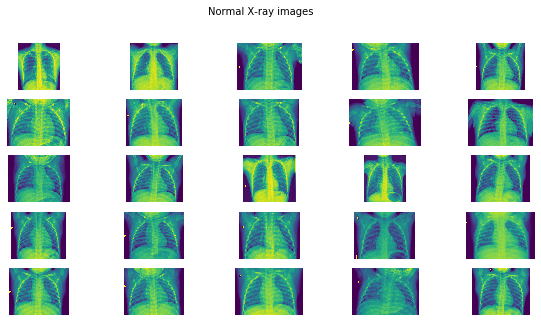

In [43]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

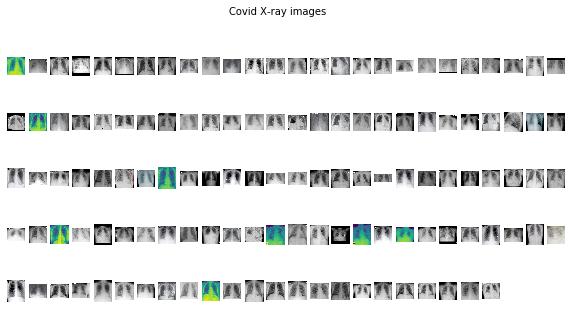

In [44]:
plots_from_files(covid_images, rows=5, maintitle="Covid X-ray images")

In [46]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(DATA_SET_DIR))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [47]:
len(data)

152

In [48]:
len(labels)

152

In [50]:
# perform one-hot encoding on the labels
lb = label_binarize(labels, classes=['covid','normal'])
#labels = lb.fit_transform(labels)
labels = to_categorical(lb)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [51]:
# and batch size
INIT_LR = 1e-3
EPOCHS = 20
BS = 8

In [52]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 40s 1us/step


In [53]:
### Training
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(trainAug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),
validation_steps=len(testX) // BS,
epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
15/15 [==============================] - 58s 4s/step - loss: 0.5284 - acc: 0.7500 - val_loss: 0.4277 - val_acc: 0.8387
Epoch 2/20
15/15 [==============================] - 52s 3s/step - loss: 0.4435 - acc: 0.8320 - val_loss: 0.4081 - val_acc: 0.8387
Epoch 3/20
15/15 [==============================] - 54s 4s/step - loss: 0.3357 - acc: 0.8662 - val_loss: 0.3555 - val_acc: 0.8387
Epoch 4/20
15/15 [==============================] - 54s 4s/step - loss: 0.3556 - acc: 0.8662 - val_loss: 0.3265 - val_acc: 0.8387
Epoch 5/20
15/15 [==============================] - 54s 4s/step - loss: 0.3110 - acc: 0.8411 - val_loss: 0.2970 - val_acc: 0.8387
Epoch 6/20
15/15 [==============================] - 55s 4s/step - loss: 0.2388 - acc: 0.9080 - val_loss: 0.2728 - val_acc: 0.8387
Epoch 7/20
15/15 [==============================] - 60s 4s/step - loss: 0.3026 - acc: 0.8750 - val_loss: 0.2423 - val_acc: 0.9032
Epoch 8/20
15/15 [======================

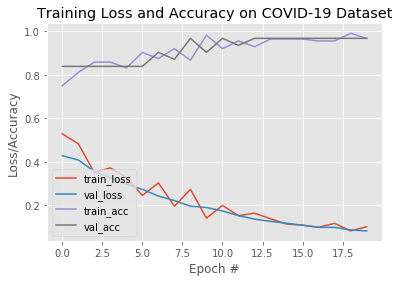

In [57]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

### Analyzing each Xray

In [58]:
#k_opt gives the optimal value of k.
def find_optimal_k(img):
    image = cv2.imread(img)
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    distortions = [] 
    inertias = [] 
    mapping1 = {} 
    mapping2 = {} 
    K = range(1,20) 
    for k in K: 
        #Building and fitting the model 
        kmeanModel = KMeans(n_clusters=k).fit(pixel_values) 
        kmeanModel.fit(pixel_values) 
        distortions.append(sum(np.min(cdist(pixel_values, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / pixel_values.shape[0]) 
        inertias.append(kmeanModel.inertia_) 
        mapping1[k] = sum(np.min(cdist(pixel_values, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / pixel_values.shape[0] 
        mapping2[k] = kmeanModel.inertia_ 
        #find the optimal value of k
        # the approximate value of k is where the dip occurs
        #here, i have taken the dip to occur at that point where the distortion values start to vary by <=2 points
    for i in K:
        if(mapping1[i] - mapping1[i+1]) <=2:
            k_opt = i
            break
    for key,val in mapping1.items(): 
        print(str(key)+' : '+str(val))
        
       
    plt.plot(K, distortions, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Distortion') 
    plt.title('The Elbow Method using Distortion') 
    plt.show()
    
    return k_opt

In [59]:
def kmeans_seg(img,k_opt):
    image = cv2.imread(img)
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    print(pixel_values.shape)
    # define stopping criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    # number of clusters (K)
    k = k_opt
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # convert back to 8 bit values
    centers1 = np.uint8(centers)
    # flatten the labels array
    labels1 = labels.flatten()
    # convert all pixels to the color of the centroids
    segmented_image = centers1[labels1.flatten()]
    # reshape back to the original image dimension
    segmented_image1 = segmented_image.reshape(image.shape)
    # show the image
    plt.title('clustered xray') 
    plt.imshow(segmented_image1)
    plt.show()
    plt.title('original xray') 
    plt.imshow(image)
    plt.show()
    

1 : 56.03537257287994
2 : 30.490967992786285
3 : 21.313632036042932
4 : 17.29506951191208
5 : 14.075692769713193
6 : 12.05967271540248
7 : 10.202869858782387
8 : 9.11192924769839
9 : 8.489007949304478
10 : 7.653342133454118
11 : 6.877269770182102
12 : 6.681443630183748
13 : 6.181316586919061
14 : 5.647960229370014
15 : 5.245706598638108
16 : 4.965447459050375
17 : 4.672575236061121
18 : 4.378546320759185
19 : 4.150310454477957


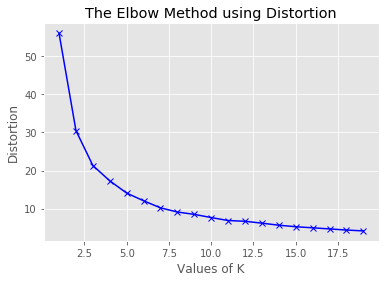

(2806496, 3)


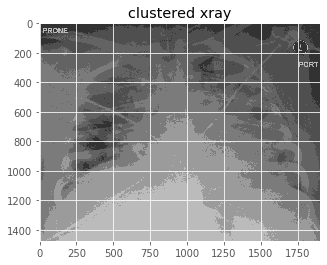

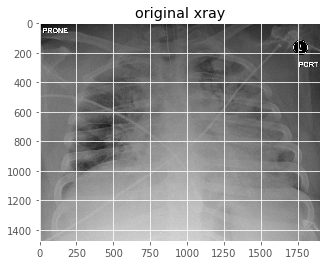

In [60]:
##Clustered on covid xray
k_opt = find_optimal_k(covid_images[1])
kmeans_seg(covid_images[1],k_opt)

In [ ]:
##Clustered on normal XRay
k_opt1 = find_optimal_k(normal_images[1])
kmeans_seg(normal_images[1],k_opt1)

1 : 93.87035874144318
2 : 45.51599772930845
3 : 33.57050129266127
4 : 25.186481359321576
5 : 19.783575479304297
6 : 16.438426175046196
7 : 14.078289675266113
8 : 12.101499452327557
9 : 10.675867777008152
10 : 9.57677301165218
11 : 8.777753908139191
12 : 7.950321131543817
13 : 7.354242176050631
14 : 6.768254429541053
15 : 6.33041345902109
16 : 5.938241305149907
17 : 5.55523217290713
18 : 5.262421814025847
19 : 4.979064659646382
